In [19]:
%load_ext autoreload
%autoreload 2

from datasets import prepare_poison_dataset
from util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
dataset_name = "clean"
train = False

simclr_model_name = f"{dataset_name}-SimCLR.pt"

dataset, true_poison_indices, _, _ = prepare_poison_dataset(dataset_name, train)
simclr, _ = load_simclr(simclr_model_name)
features, labels_poison, labels_true = extract_simclr_features(simclr, dataset, layer="repr")
num_classes = int(max(labels_poison).item())

In [21]:
# Hiperparameters

n_neighbors = int(len(dataset) / 500)

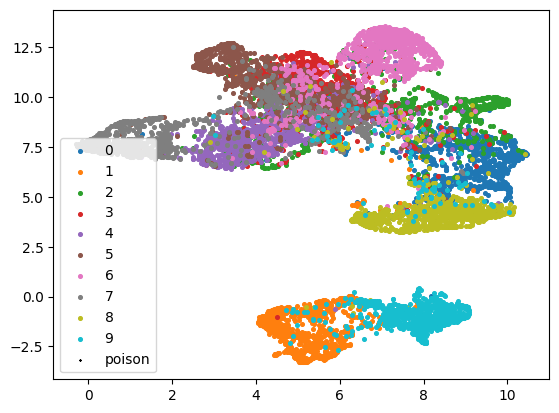

In [22]:
features_2d = calculate_features_2d(features, n_neighbors=n_neighbors)
plot_features_2d(features_2d, labels_poison, true_poison_indices, legend=True)

In [23]:
# Nondisruptive cleanse
predicted_poison_indices_nondisruptive = knn_cleanse(features, labels_poison, n_neighbors=n_neighbors)
print_evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)

0 	 1717
0 	 8283
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  82.83%
Percentage of remaining poisoned images (out of all remaining):  0.00%


In [24]:
# Disruptive cleanse
#predicted_poison_indices_disruptive = gauss_cleanse(features_2d, gauss_discard, poison_indices=true_poison_indices)
predicted_poison_indices_disruptive = kmeans_cleanse(features_2d, means=11, mode="distance")
print_evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices)

0 	 931
0 	 9069
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  90.69%
Percentage of remaining poisoned images (out of all remaining):  0.00%


In [25]:
# Combine cleanses

predicted_poison_indices_final = predicted_poison_indices_nondisruptive | predicted_poison_indices_disruptive
print_evaluate_cleanse(predicted_poison_indices_final, true_poison_indices)

0 	 2608
0 	 7392
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  73.92%
Percentage of remaining poisoned images (out of all remaining):  0.00%


In [26]:
#poison_multiclass_classifier_model = train_multiclass_classifier(dataset, predicted_poison_indices_final)
#poison_multiclass_classifier_model = train_binary_classifier(dataset, predicted_poison_indices_final)

In [27]:
#predicted_poison_indices_multiclass_reclassification = multiclass_reclassification(dataset, poison_multiclass_classifier_model, labels_poison)
#predicted_poison_indices_multiclass_reclassification = binary_reclassification(dataset, poison_multiclass_classifier_model)
#print_evaluate_cleanse(predicted_poison_indices_multiclass_reclassification, true_poison_indices)

In [28]:
# Final cleanse report
print("---------------------------------------")
train_string = "train" if train else "test"
print(f"{dataset_name} {train_string}")
print("\nNon-disruptive cleanse: ")
print_evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)
print("\nDisruptive cleanse: ")
print_evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices)
print("\nCombined cleanse: ")
print_evaluate_cleanse(predicted_poison_indices_final, true_poison_indices)
#print("\nReclassify (multiclass) combined cleanse: ")
#print_evaluate_cleanse(predicted_poison_indices_multiclass_reclassification, true_poison_indices)
print("---------------------------------------")

---------------------------------------
clean test

Non-disruptive cleanse: 
0 	 1717
0 	 8283
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  82.83%
Percentage of remaining poisoned images (out of all remaining):  0.00%

Disruptive cleanse: 
0 	 931
0 	 9069
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  90.69%
Percentage of remaining poisoned images (out of all remaining):  0.00%

Combined cleanse: 
0 	 2608
0 	 7392
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  73.92%
Percentage of remaining poisoned images (out of all remaining):  0.00%
---------------------------------------


In [29]:
import pickle

def save_predicted_indices(predicted_indices: np.array, save_name: str):
    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(predicted_indices, f)


train_str = "train" if train else "test"
save_name = f"{dataset_name}-{train_str}-NEW"
save_predicted_indices(predicted_poison_indices_final, save_name)